### Approaches to Solving MDPs II: Monte Carlo

Last updated: March 15, 2022


### SOURCES 

- Reinforcement Learning, RS Sutton & AG Barto, 2nd edition. Chapter 5
- Mastering Reinforcement Learning with Python, Enes Bilgin. Chapter 5

### LEARNING OUTCOMES

- Apply Monte Carlo simulaton to estimate value functions
- Understand the strengths and limitations of Monte Carlo methods

### CONCEPTS

- Monte Carlo simulation can be used to measure value functions without knowledge of transition probabilities
- Exploring starts
- Simulation risk


---  

### Monte Carlo (MC) Methods

MC does not require complete knowledge of the environment.

Instead, it relies on sampling by simulating many trajectories, where a trajectory looks like: $s_t,a_t,r_{t+1},s_{t+1},a_{t+1},r_{t+2},s_{t+2},...,r_T,s_T$

For measuring state value function $v_\pi(s)$ and action value function $q_\pi(s,a)$,  
- start with $s$ in the former and $s, a$ in the latter  
- generate many sample trajectories: sequences of state-action-reward tuples
- compute the mean

One challenge with computing $q_\pi(s,a)$ by simulation is that many state-action pairs $(s,a)$ may not be visited  
Can force a given $(s,a)$ by starting an episode in that condition; called **exploring starts.**

**MC is an approximation**: while the true values would require infinite simulated trajectories, we can get *close enough* by simulating a massive number of paths.

MC makes updates with trajectories are completed.

**Blackjack!**: next we simulate blackjack to study policies and values. If we wanted to use DP, this would be very hard as transition probabilities need to be computed in advance. 

![basic_strategy](images/blackjack_basic_strategy.jpg)

#### Blackjack Policy Simulator

The object of the game is to obtain cards with total value as great as possible without exceeding 21 and beat the dealer.

The rules:

- Face card values are 10
- Ace value is 1 or 11
- Two cards are dealt to player and dealer
- One of the dealer's cards is face up
- If the player has 21 and the dealer doesn't, the player wins
- If the player has 21 and the dealer has 21, it is a draw
- If the player does not have 21, he can draw cards until he stops (sticks) or exceeds 21 (goes bust)
- If he goes bust, he loses
- If he sticks, it is the dealer's turn
- The dealer must stick on a sum of 17 or greater and hits otherwise
- If the dealer goes bust, the player wins. Otherwise, the winner has final sum closer to 21.

Assumption

- infinite card deck

Policy

- a simple policy we can consider: player sticks if sum greater than *max_total_hit*, else hits  

A more complete policy will choose based on 1) sum of player cards 2) dealer card shown 3) player having usable aces

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class CardGenerator():
    def __init__(self):
        self.card_values = [2,3,4,5,6,7,8,9,10,11]
        self.weights=[1/13]*8 + [4/13] + [1/13]

    def draw_card(self):
        return random.choices(self.card_values, self.weights)[0]

In [3]:
class BasePlayer():
    def __init__(self, verbose, name):
        self.verbose     = verbose
        self.name        = name
        self.total       = 0
        self.usable_aces = 0
        self.card_gen    = CardGenerator()
        self.is_busted   = False
        
        # draw two cards and manage aces
        new_card = self.card_gen.draw_card()
        if self.verbose:
            print(self.name)
            print('card1', new_card)
        self.total += new_card
        self.manage_possible_ace(new_card)
        new_card = self.card_gen.draw_card()
        if self.verbose:
            print('card2', new_card)
        self.total += new_card
        self.manage_possible_ace(new_card)
        
    def manage_possible_ace(self, new_card):
        if new_card == 11:
            if self.total > 21:
                self.total -= 10
            else:
                self.usable_aces += 1

    def is_over21(self):
        if self.total > 21:
            if self.usable_aces > 0:
                self.total -= 10
                self.usable_aces -= 1
            else:
                self.is_busted = True
    
    def report_status(self):
        print('total', self.total)
        print('usable_aces', self.usable_aces)
        print('is_busted',self.is_busted)
        print('\n')
        

In [9]:
class Player(BasePlayer):
    def __init__(self, verbose, name, max_total_hit):
        super().__init__(verbose, name)
        self.max_total_hit = max_total_hit
        
        if self.verbose:
            self.report_status()

    def followup_play(self):
        while self.total <= self.max_total_hit: 
            print(self.name, 'draws a card...')
            new_card = self.card_gen.draw_card()
            self.total += new_card  
            self.manage_possible_ace(new_card)   
            self.is_over21()
            if self.verbose:
                print('new_card', new_card)
                self.report_status()


In [10]:
def compare_end(player, dealer):
    #print('player total', player.total)
    #print('dealer total', dealer.total)
    
    if player.total > dealer.total:
        return 1
    elif player.total == dealer.total:
        return 0
    else:
        return -1
    
def player_vs_dealer(player, dealer): 
    
    if player.total == 21:
        if dealer.total != 21:
            return 1
        elif dealer.total == 21:
            return 0
    else:
        player.followup_play()
        if player.is_busted:
            print(player.name, 'busted')
            return -1
        else:
            dealer.followup_play()
            if dealer.is_busted:
                print(dealer.name, 'busted')
                return 1
            else:
                return compare_end(player, dealer)
                

#### Simulate a hand of blackjack

In [11]:
verbose = True
max_total_hit = 18

plr = Player(verbose, 'Austin Powers', max_total_hit)
dealer = Player(verbose, 'Number Two', 16)

reward = player_vs_dealer(plr, dealer)
print(reward)

Austin Powers
card1 10
card2 10
total 20
usable_aces 0
is_busted False


Number Two
card1 8
card2 8
total 16
usable_aces 0
is_busted False


Number Two draws a card...
new_card 11
total 17
usable_aces 0
is_busted False


1


#### Simulate a large number of hands for various *max_total_hit* and compute mean reward for each

Dealer draws a card...
Player draws a card...
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Player draws a card...
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Deale

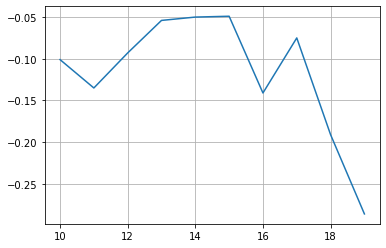

In [15]:
its = 1000

thresholds = np.arange(10,20)
mean_rewards = np.empty(len(thresholds))

ix = 0
for thresh in thresholds:
    sum_rewards = 0
    for it in range(its):
        plr = Player(False, 'Player', thresh)
        dealer = Player(False, 'Dealer', 16)
        sum_rewards += player_vs_dealer(plr, dealer)
    mean_rewards[ix] = sum_rewards/its
    ix += 1

plt.plot(thresholds, mean_rewards)
plt.grid()
plt.show()

This gives understanding of value of different policies: at which sum should player stick

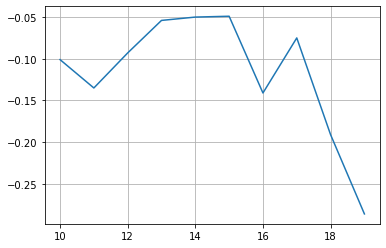

In [16]:
plt.plot(thresholds, mean_rewards)
plt.grid()
plt.show()

**Exercise 1**  

Think about how you can modify the code to allow the policy to additionally depend on the dealer upcard

**Exercise 2**  

Consider a policy where the player sticks on sum 19-21 and hits otherwise.  
How might you estimate the value of this policy given a state where player sum is 13 and dealer upcard is 5?

**Exercise 3**

If you wish to measure the various state-value combinations (player starting sum, dealer upcard, player usable aces), how can this be done efficiently?

---

#### Limitations to Monte Carlo

- Need to wait for a trajectory to be finalized before value update can be made  
Example: you estimate commute time before the trip starts. Midway into the trip, you realize you're running 30 minutes late.  
You can't update your estimate until you finish the trip. Is this realistic? Can you do better?

- The simulated environment needs to match reality: **simulation risk**  
If there is a gap between simulated environment and reality, the model may fail in deployment.

For these reasons, there was a push to develop better approaches such as temporal-difference methods.  
We discuss these next.

---